# Look again at the data from the article

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc3 as pm
#import theano
import theano.tensor as tt

In [2]:
frame = pd.read_csv("with_stem.csv")

In [79]:
x = np.vstack([frame["STEM"].values, frame["HWOC"].values, frame["SELA"].values,
               frame["SvsE"].values, frame["FAB"].values]).T
# Add constant row
xx = np.vstack([[1]*30, *x.T]).T
y = frame["FEM"].values

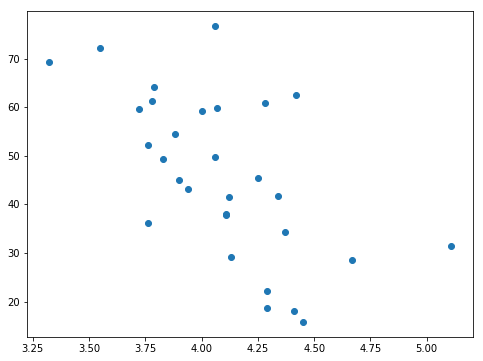

In [80]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x.T[-1], y)

In [81]:
with pm.Model() as model:
    beta = pm.Flat("beta", shape=(xx.shape[1],))
    mean = tt.dot(xx, beta)

    s = pm.Flat("s")
    sigma2 = pm.Deterministic("sigma2", np.exp(s))
    
    obs = pm.MvNormal("y", mu=mean, cov = sigma2 * np.eye(y.shape[0]), observed=y)
    
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|███████████████████████████████████▉| 10999/11000 [15:18<00:00, 11.98it/s]C:\Users\MattUser\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 9 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|████████████████████████████████████| 11000/11000 [15:18<00:00, 11.98it/s]


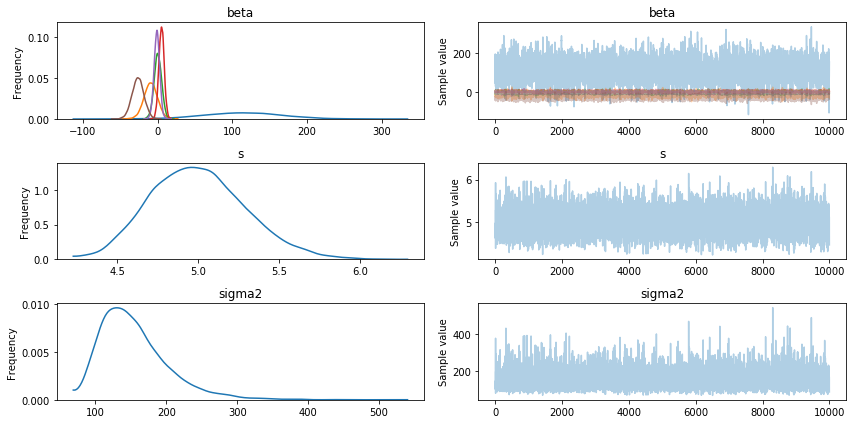

In [82]:
axes = pm.traceplot(trace)

In [85]:
beta = trace.get_values("beta")
residual_y = y[None,:] - np.sum(beta[:,None,:-1] * xx[None,:,:-1], axis=-1)
residual_x = xx[:,-1]

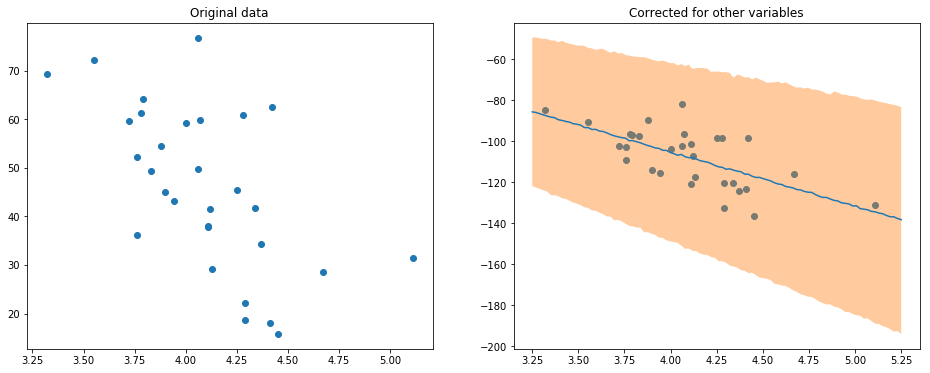

In [87]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

axes[0].scatter(residual_x, y)
axes[0].set_title("Original data")

axes[1].scatter(residual_x, np.median(residual_y, axis=0))

xcs = np.linspace(3.25,5.25,100)
c = beta[:,None,-1] * xcs[None,:]
samples = np.random.normal(loc = c, scale = np.sqrt(trace.get_values("sigma2"))[:,None])
axes[1].plot(xcs, np.median(samples, axis=0))
lower, upper = np.percentile(samples, [10,90], axis=0)
axes[1].fill_between(xcs, lower, upper, alpha=0.4)
axes[1].set_title("Corrected for other variables")
None

In [88]:
import corner

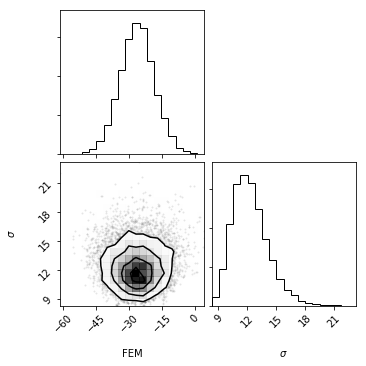

In [99]:
samples = np.asarray([beta[:,-1], np.sqrt(trace.get_values("sigma2"))])
fig = corner.corner(samples.T, labels=["FEM", "$\sigma$"])

So the "response" of the FEM variable is predicted to be in the range -45 to -15, with a mode of around -30.  The standard deviation of error is around 12.

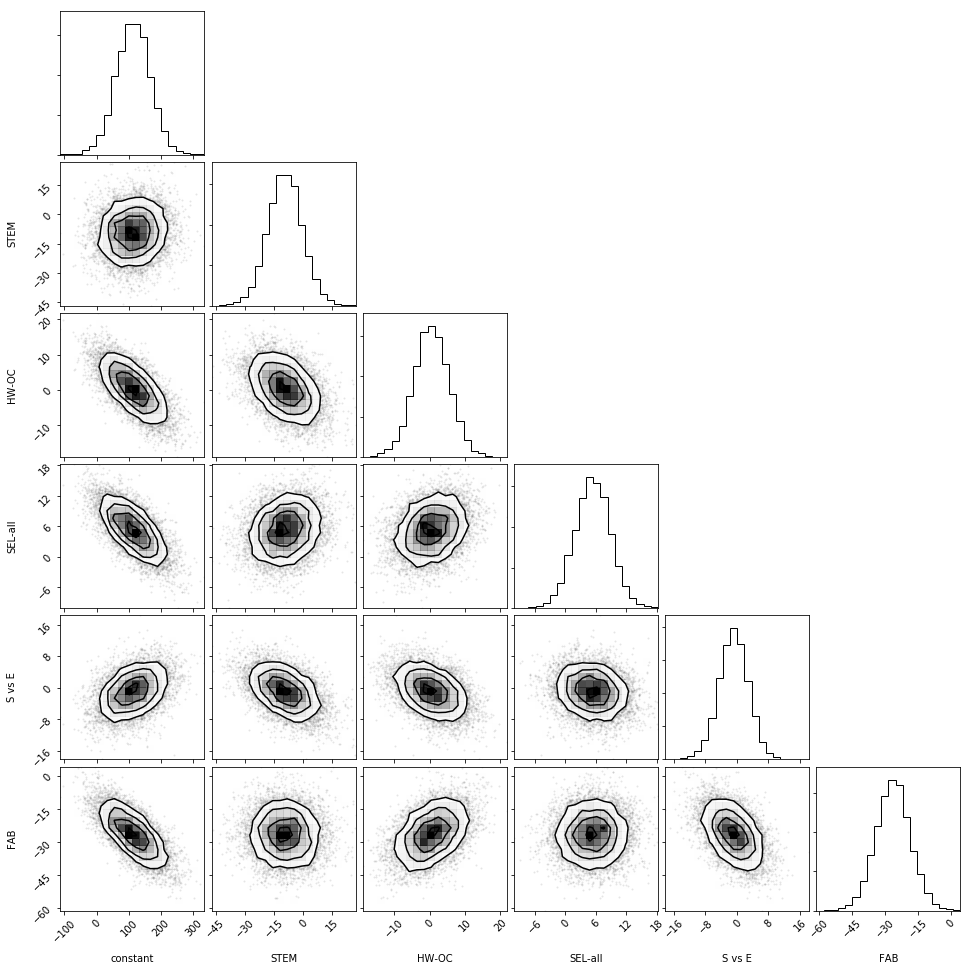

In [98]:
fig = corner.corner(beta, labels=["constant", "STEM", "HW-OC", "SEL-all", "S vs E", "FAB"])